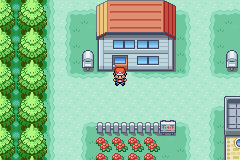

In [16]:
import PIL
from PIL import Image
import numpy as np

QRFLAG = "TUDCTF{color_palette_town}"
EXIFFLAG = "TUDCTF{exfiltrating_the_exif}"
ZIPFLAG = "TUDCTF{evidence.zip}"
HEIGHTFLAG = "TUDCTF{at_the_height_of_hiding}"

# Open the image
im = Image.open("orig.png")
display(im)

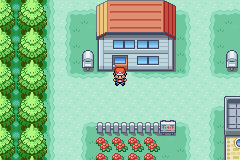

In [17]:
result = im.convert('P', palette = Image.ADAPTIVE)
display(result)

768 256


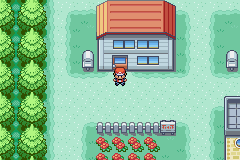

In [18]:
import qrcode

qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(QRFLAG)
qr.make(fit=True)

qr_img = qr.make_image(fill_color="black", back_color="white")
min_dim = min(result.size)
qr_img.resize((min_dim, min_dim))
# pad the qr code to the same size as the image
qr_img = qr_img.resize((result.size[0], result.size[1]))

qr_img = np.array(qr_img).astype(np.uint8)

result_arr = np.array(result).astype(np.uint8)
result_arr = result_arr + qr_img * 64
result.putdata(result_arr.flatten())
new_palette = result.getpalette()[:64*3] + result.getpalette()[:64*3] + result.getpalette()[:64*3] + result.getpalette()[:64*3]
print(len(new_palette), len(new_palette)//3)
result.putpalette(new_palette)
display(result)
result.save("with_qr.png")

In [19]:
# hide in exif
from PIL.ExifTags import TAGS
import base64

img_exif = result.getexif()
img_exif[0x9286] = base64.b64encode(EXIFFLAG.encode("ascii"))
img_exif[0x927C] = "password=Obamium"
result.save("with_qr_exif.png", exif=img_exif)

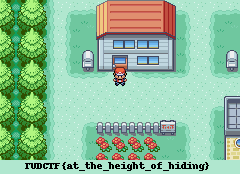

In [20]:
from PIL import ImageDraw
# Hide extra stuff in height
original_height = result.size[1]
# pad 50px down
result = result.crop((0, 0, result.size[0], result.size[1] + 14))
# add the flag
draw = ImageDraw.Draw(result)
draw.text((25, original_height), HEIGHTFLAG, fill=(0, 0, 0))
# revert height bitwise
result.save("with_qr_exif_height.png", exif=img_exif)
display(result)

In [21]:
# Set height to orig_height without removing the data
with open("with_qr_exif_height.png", "rb") as f:
    data = bytearray(f.read())

data[0x17] = original_height & 0xFF

#CRC = 05051157
data[0x1D] = 0x05
data[0x1E] = 0x05
data[0x1F] = 0x11
data[0x20] = 0x57

with open("with_qr_exif_height.png", "wb") as f:
    f.write(data)

In [22]:
# hide zip file in image
import pyminizip

# write flag
with open("flag.txt", "w") as f:
    f.write(ZIPFLAG)

pyminizip.compress("flag.txt", None, "vault.zip", "Obamium", 0)

# hide zip file in image
with open("vault.zip", "rb") as f:
    zip_data = f.read()

with open("with_qr_exif_height.png", "rb") as f:
    img_data = f.read()

with open("with_qr_exif_height_zip.png", "wb") as f:
    f.write(img_data + zip_data)